# Homework 4

## FINM 35700 - Spring 2024

### UChicago Financial Mathematics

### Due Date: 2025-04-22

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

Interest Rate & Credit Default Swaps
- the SOFR OIS symbology file `sofr_swap_symbology`,
- the SOFR swaps market data file `sofr_swaps_market_data_eod`,
- the CDS spreads market data file `cds_market_data_eod`.

HYG ETF corporate bonds:
- the HYG bond symbology file `hyg_bond_symbology` and
- the HYG basket composition file (containing bond weights and yields) `hyg_basket_composition`.

In [1]:
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import scipy.optimize as opt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

-----------------------------------------------------------
# Problem 1: Fixed rate bond prices and sensitivities (bond yield model)

## When computing sensitivities, assume "everything else being equal" (ceteris paribus).

For a better understanding of dependencies, you can use the simple fixed rate bond valuation formula in the flat yield model (formula [6] in Lecture 1).

\begin{align}
PV_{Bond}\left(c,T,y_{sa} \right)=1+\frac{c-y_{sa}}{y_{sa}}\cdot\left[1-\left(1+\frac{y_{sa}}{2}\right)^{-2T}\right]
\end{align}


## a. True or False (fixed rate bond prices)

1. Fixed rate bond price is increasing in yield. **False**
2. Fixed rate bond price is increasing in coupon  **True**
3. Fixed rate bond price is increasing in bond maturity **False**
4. Fixed rate callable bond prices are higher or equal to their "bullet" (non-callable) version. **False**


## b. True or False (fixed rate bond yields)

1. Fixed rate bond yield is increasing in interest rate (assuming credit spread unchanged)    **True**
2. Fixed rate bond yield is increasing in credit spread (assuming interest rate unchanged)    **True** 
3. Fixed rate bond yield is increasing in coupon   **False**
4. Fixed rate bond yield is increasing in bond maturity (assume term structure of yield curve is known)    **False**


## c. True or False (fixed rate bond durations)

1. Fixed rate bond duration is increasing with yield    **False**
2. Fixed rate bond duration is increasing in coupon     **False**
3. Fixed rate bond duration is increasing with bond maturity    **True**
4. Fixed rate callable bond durations are higher or equal to their "bullet" (non-callable) version.    **False**


## d. True or False (fixed rate bond convexities)

1. Fixed rate bond convexity is increasing with yield    **False**
2. Fixed rate bond convexity is increasing in coupon     **False**
3. Fixed rate bond convexity is increasing with bond maturity    **True**
4. Fixed rate callable bond convexities are higher or equal to their "bullet" (non-callable) version.    **False**


-----------------------------------------------------------
# Problem 2: US SOFR swap curve calibration as of 2024-12-13
### Follow Section "1. SOFR OIS swap rates and SOFR discount curve calibration + validation" in the QuantLib Advanced notebook !

## a. Load and explore US SOFR swaps symbology and market data

Load the `sofr_swap_symbology` Excel file into a dataframe. Print all swap tenors available.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe. Print all dates available.

Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.

In [3]:
sofr_sym = pd.read_excel('data/sofr_swaps_symbology.xlsx')
tenors = sorted(sofr_sym['tenor'].unique())
print("SOFR Swaps Symbology:")
display(sofr_sym.head())
print('Available swap tenors:', tenors)

sofr_mkt = pd.read_excel('data/sofr_swaps_market_data_eod.xlsx')
sofr_mkt['date'] = pd.to_datetime(sofr_mkt['date'])
print("\n SOFR Swaps Market Data EOD")
display(sofr_mkt.head())

SOFR Swaps Symbology:


,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
1,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
2,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
3,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV
4,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV


Available swap tenors: [1, 2, 3, 5, 7, 10, 20, 30]

 SOFR Swaps Market Data EOD


,date,figi,bidRate,askRate,midRate
0,2024-01-02,BBG00KFWPJJ9,4.7960,4.8046,4.80030
1,2024-01-02,BBG00KFWPJX3,4.1368,4.1452,4.14100
2,2024-01-02,BBG00KFWPK15,3.8258,3.8327,3.82925
3,2024-01-02,BBG00KFWPK51,3.5907,3.5943,3.59250
4,2024-01-02,BBG00KFWPK79,3.5297,3.5333,3.53150


In [4]:
df = sofr_sym.merge(sofr_mkt, on='figi').sort_values('date')
display(df.head())
print(df.shape)

,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status,date,bidRate,askRate,midRate
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV,2024-01-02,4.7960,4.8046,4.80030
470,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV,2024-01-02,3.8258,3.8327,3.82925
1175,BBG00KFWPKB4,USOSFR10,Curncy,USOSFR10 Curncy,USD OIS ANN VS SOFR 10Y,10,SWAP,ACT/360,NONE,US,USD,ACTV,2024-01-02,3.5142,3.5179,3.51605
1410,BBG00KFWPKF0,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV,2024-01-02,3.5179,3.5230,3.52045
1644,BBG00KFWPKH8,USOSFR30,Curncy,USOSFR30 Curncy,USD OIS ANN VS SOFR 30Y,30,SWAP,ACT/360,NONE,US,USD,ACTV,2024-01-02,3.3466,3.3522,3.34940


(1879, 16)


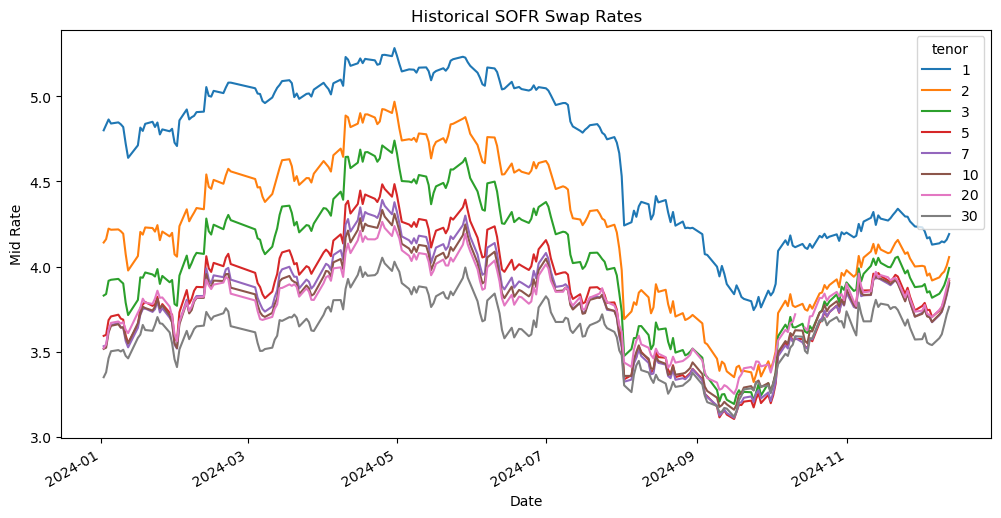

In [5]:
df_hist = df[df['tenor'].isin(tenors)].pivot(index='date', columns='tenor', values='midRate')
fig, ax = plt.subplots(figsize=(12,6))
df_hist.plot(ax=ax)
ax.set(title='Historical SOFR Swap Rates', xlabel='Date', ylabel='Mid Rate')
plt.show()

## b. Calibrate the US SOFR yield curve (via bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from SOFR swaps. 

Prepare a joint symbology & market dataframe quotes as of 2024-12-13. 

Calibrate the SOFR discount factor curve as of 2024-12-13.

Follow section 1b in the QuantLib Advanced notebook.

In [6]:
def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='tenor')    
    
    # settle_days
    settle_days = 1
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['tenor']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

In [7]:
df_2024_12_13 = df[df['date'] == '2024-12-13']
display(df_2024_12_13)

,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status,date,bidRate,askRate,midRate
939,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.9133,3.9181,3.91570
1409,BBG00KFWPKB4,USOSFR10,Curncy,USOSFR10 Curncy,USD OIS ANN VS SOFR 10Y,10,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.9015,3.9065,3.90400
1174,BBG00KFWPK79,USOSFR7,Curncy,USOSFR7 Curncy,USD OIS ANN VS SOFR 7Y,7,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.8937,3.8991,3.89640
704,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.9883,3.9944,3.99135
469,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,4.0524,4.0585,4.05545
234,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,4.1858,4.1958,4.19080
1643,BBG00KFWPKF0,USOSFR20,Curncy,USOSFR20 Curncy,USD OIS ANN VS SOFR 20Y,20,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.9246,3.9304,3.92750
1878,BBG00KFWPKH8,USOSFR30,Curncy,USOSFR30 Curncy,USD OIS ANN VS SOFR 30Y,30,SWAP,ACT/360,NONE,US,USD,ACTV,2024-12-13,3.7602,3.7662,3.76320


In [8]:
sofr_yc = calibrate_sofr_curve_from_frame(calc_date, df_2024_12_13, 'midRate')

## c. Display the calibrated SOFR discount curve dataframe

Follow section 1d (in the QuantLib Advanced notebook) to display the calibration details dataframe.

In [9]:
grid_dates = [sofr_yc.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yc)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yc, grid_dates)     # using external grid

display(sofr_yield_curve_simple_df)
display(sofr_yield_curve_details_df)

,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-16,0.000,1.000,4.190
1,2025-12-16,1.014,0.959,4.190
2,2026-12-16,2.028,0.923,4.052
3,2027-12-16,3.042,0.888,3.986
4,2029-12-17,5.075,0.823,3.907
5,2031-12-16,7.100,0.763,3.888
6,2034-12-18,10.150,0.678,3.899
7,2044-12-16,20.292,0.457,3.931
8,2054-12-16,30.436,0.333,3.676


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-16,0.000,1.000,4.190
1,2026-12-16,2.028,0.923,4.052
2,2028-12-16,4.058,0.855,3.946
3,2030-12-16,6.086,0.792,3.897
4,2032-12-16,8.117,0.734,3.892
5,2034-12-16,10.144,0.678,3.899
6,2036-12-16,12.175,0.627,3.905
7,2038-12-16,14.203,0.580,3.912
8,2040-12-16,16.233,0.536,3.918
9,2042-12-16,18.261,0.495,3.925


## d. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves

Plot the SOFR zero rates and discount factor curves by maturity. Follow section 1c in the QuantLib Advanced notebook.

Text(0.5, 0, 'Date')

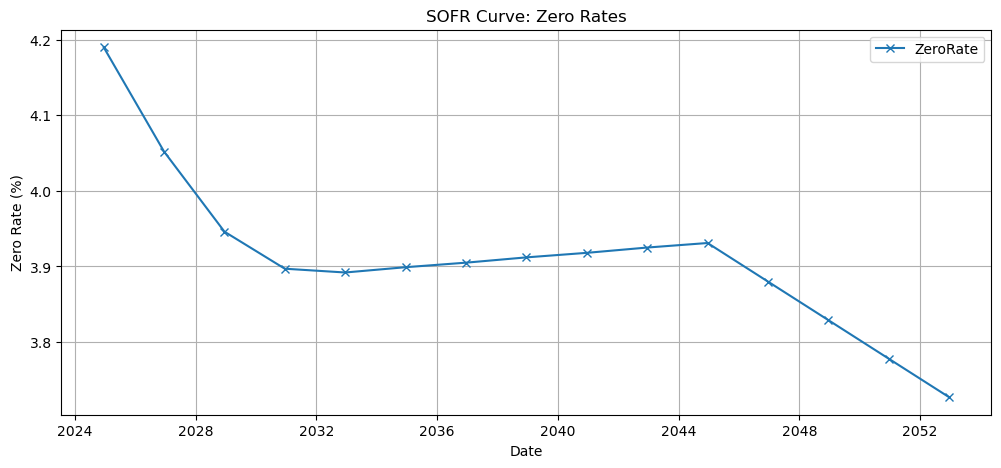

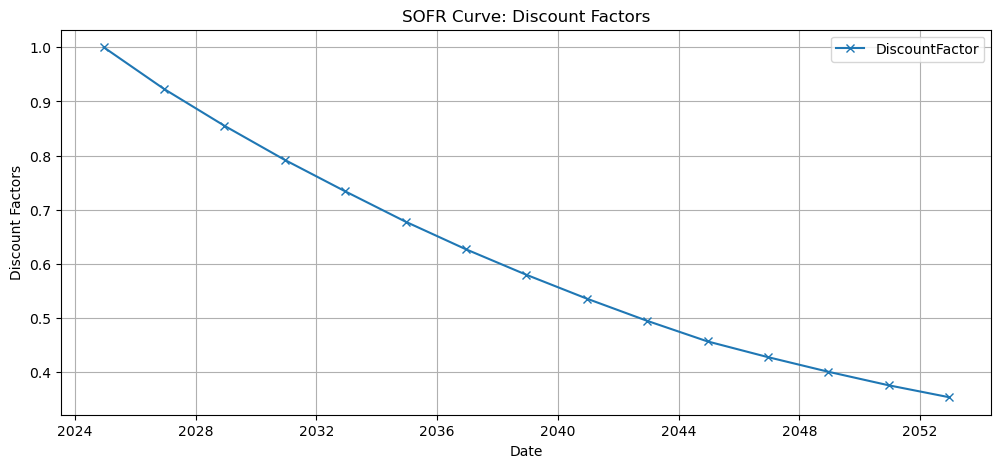

In [10]:
plt = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, title='SOFR Curve: Zero Rates', figsize=(12,5), marker='x')
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, title='SOFR Curve: Discount Factors', figsize=(12,5), marker='x')
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

-----------------------------------------------------------
# Problem 3: CDS Hazard Rate calibration and valuation
## Follow Section "2. CDS Hazard Rate calibration + Pricing" in the QuantLib Advanced notebook !!!

## a. Load and explore the CDS market data (IBM credit issuer)

Load the `cds_market_data_eod` Excel file into a dataframe. 

Plot the historical time series of CDS Par Spreads for the available tenors.


In [11]:
cds = pd.read_excel('data/cds_market_data_eod.xlsx')
cds['date'] = pd.to_datetime(cds['date'])
cds.sort_values(by='date', inplace=True)
display(cds.head())

,date,ticker,short_name,tier,sector,region,currency,doc_clause,running_coupon,cds_assumed_recovery,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
0,2024-01-02,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,13.6831,18.8194,28.3917,44.7053,62.1494,69.1972
1,2024-01-03,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,14.2256,19.6610,29.4493,46.4866,63.6475,71.4311
2,2024-01-04,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,13.8318,19.1828,28.8454,45.4735,62.6543,70.9180
3,2024-01-05,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,13.6181,18.7703,28.3417,44.7575,61.9778,70.2746
4,2024-01-08,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,13.4433,18.3692,27.7599,43.8548,60.8378,68.8914


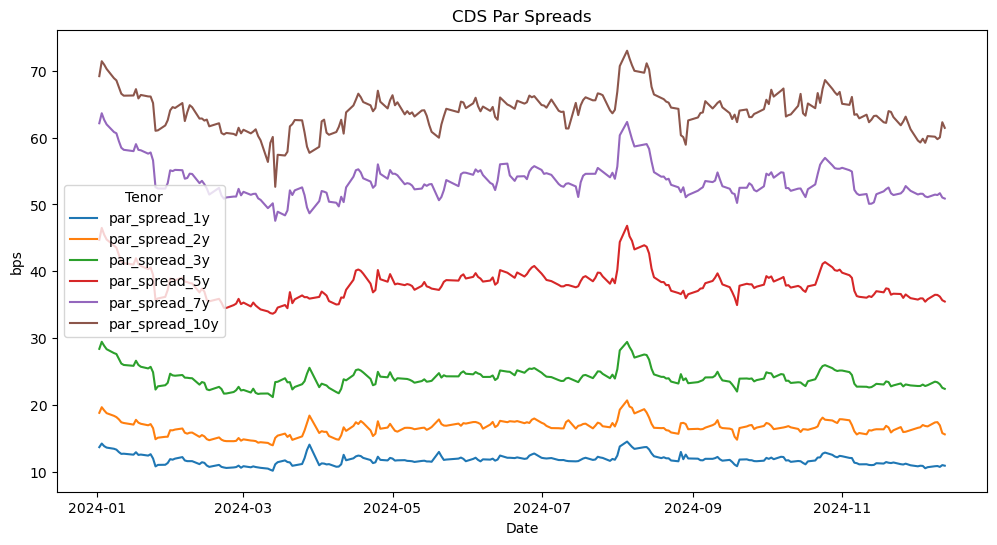

In [12]:
import matplotlib.pyplot as plt 
cols = ['par_spread_1y', 'par_spread_2y', 'par_spread_3y', 'par_spread_5y', 'par_spread_7y', 'par_spread_10y']

fig, ax = plt.subplots(figsize=(12,6))
for c in cols:
    ax.plot(cds['date'], cds[c], label=c)
ax.legend(title='Tenor'); ax.set(title='CDS Par Spreads', xlabel='Date', ylabel='bps')
plt.show()

## b. Calibrate the IBM hazard rate curve as of 2024-12-13

Follow section 2a in the QuantLib Advanced notebook. Use the calibrated SOFR discount curve from Problem 2b.

In [13]:
cds_ibm = cds[(cds['date'] == '2024-12-13') & (cds['ticker'] == 'IBM')]
display(cds_ibm)

,date,ticker,short_name,tier,sector,region,currency,doc_clause,running_coupon,cds_assumed_recovery,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
238,2024-12-13,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,10.9082,15.6009,22.4095,35.4733,50.8816,61.462


In [14]:
sofr_yc_handle = ql.YieldTermStructureHandle(sofr_yc) 
row = cds_ibm.iloc[0]
spreads = [row[c] for c in cols]
recovery = row['cds_assumed_recovery']
hazard = calibrate_cds_hazard_rate_curve(calc_date, sofr_yc_handle, spreads, recovery)

hazard_list = [(hr[0].to_date(), 
                ql.Actual360().yearFraction(calc_date, hr[0]),
                hr[1] * 100,
                hazard.survivalProbability(hr[0])) 
                for hr in hazard.nodes()]

grid_date, year_fraction, hazard_rate, survival_probability = zip(*hazard_list)
hazard_rates = pd.DataFrame(data={'Date': grid_date, 
                                     'Year Fraction': year_fraction,
                                     'Hazard Rate': hazard_rate,
                                     'Survival Probability': survival_probability})
display(hazard_rates)

,Date,Year Fraction,Hazard Rate,Survival Probability
0,2024-12-13,0.000000,0.179862,1.000000
1,2025-12-22,1.038889,0.179862,0.998133
2,2026-12-21,2.050000,0.341810,0.994690
3,2027-12-20,3.061111,0.614840,0.988525
4,2029-12-20,5.091667,0.953377,0.969572
5,2031-12-22,7.125000,1.604396,0.938453
6,2034-12-20,10.163889,1.551602,0.895230


## c. Plot the calibrated Hazard Rates and Survival Probability curves
Follow section 2b in the QuantLib Advanced notebook. Use the calibrated SOFR discount curve from Problem 2b.

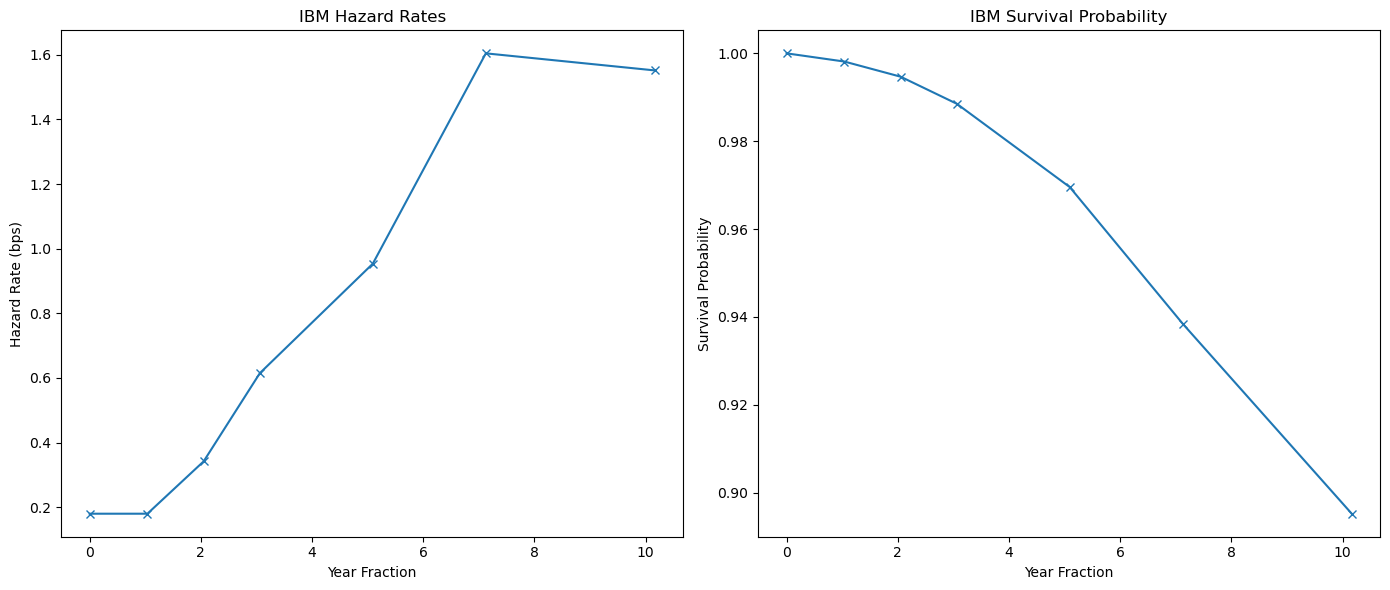

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(hazard_rates['Year Fraction'], hazard_rates['Hazard Rate'], marker='x')
ax1.set(title='IBM Hazard Rates', xlabel='Year Fraction', ylabel='Hazard Rate (bps)')
ax2.plot(hazard_rates['Year Fraction'], hazard_rates['Survival Probability'], marker='x')
ax2.set(title='IBM Survival Probability', xlabel='Year Fraction', ylabel='Survival Probability')
plt.tight_layout(); plt.show()

## d. Compute the fair/par spread and PV of a 5 year CDS contract

Follow section 2c in the QuantLib Advanced notebook. Construct a CDS object with 100 bps coupon and 2029-06-20 maturity. Compute the fair/par spread and PV.


In [16]:
sched = ql.MakeSchedule(
    effectiveDate=calc_date,
    terminationDate=ql.Date(20, 6, 2029),
    tenor=ql.Period(3, ql.Months),
    calendar=ql.TARGET(),
    convention=ql.Following,
    terminalDateConvention=ql.Unadjusted,
    rule=ql.DateGeneration.TwentiethIMM,
    endOfMonth=False
)

In [17]:
cds_inst = ql.CreditDefaultSwap(
    ql.Protection.Seller, 100, 1e-2, sched, ql.Following, ql.Actual360()
)
prob = ql.DefaultProbabilityTermStructureHandle(hazard)
engine = ql.MidPointCdsEngine(prob, recovery, sofr_yc_handle)
cds_inst.setPricingEngine(engine)

In [18]:
print('Fair Spread (bps):', round(cds_inst.fairSpread()*1e4,3))
print('NPV:', round(cds_inst.NPV(),4))
print('Premium Leg PV:', round(cds_inst.couponLegNPV(),4))
print('Default Leg PV:', round(cds_inst.defaultLegNPV(),4))
print('Survival Probability:', round(hazard.survivalProbability(ql.Date(20,6,2029)),4))

Fair Spread (bps): 33.238
NPV: 2.7634
Premium Leg PV: 4.1391
Default Leg PV: -1.3758
Survival Probability: 0.9743


-----------------------------------------------------------
# Problem 4: Credit ETF analysis on HYG (iShares High Yield Corporate Bond ETF)

## a. Load and explore the HYG basket composition and market data

Load the `hyg_basket_composition` Excel file into a dataframe. It contains the HYG basket constituent face notionals, weights and yields-to-maturities as of 2024-12-13.

Load the `hyg_corp_symbology` Excel file into a dataframe. It contains the corporate bond details for HYG constituents.

How many corporate bonds are in the HYG basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the HYG basket? What are the average and median face notionals for a ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.

In [19]:
hyg_basket_composition = pd.read_excel('data/hyg_basket_composition.xlsx')
display(hyg_basket_composition.head())
hyg_corp_symbology = pd.read_excel('data/hyg_corp_symbology.xlsx')
display(hyg_corp_symbology.head())

,date,etf_ticker,figi,isin,security,description,coupon,maturity,cpn_type,class,currency,bidYield,askYield,midYield,face_notional,face_notional_weight
0,2024-12-13,HYG,BBG00Z3K0YS9,US00489LAF04,ACRISU 4 1/4 02/15/29,ACRISURE LLC 4.25 02/15/2029 144a (SECURED),4.250,2029-02-15,FIXED,Corp,USD,5.674,5.439,5.5565,9750000,0.062760
1,2024-12-13,HYG,BBG011Y6QG29,US00489LAH69,ACRISU 6 08/01/29,ACRISURE LLC 6.0 08/01/2029 144a (SENIOR),6.000,2029-08-01,FIXED,Corp,USD,6.790,6.578,6.6840,7152000,0.046038
2,2024-12-13,HYG,BBG00DHXNL44,US00687YAA38,ADNT 4 7/8 08/15/26,ADIENT GLOBAL HOLDINGS LTD 4.875 08/15/2026 14...,4.875,2026-08-15,FIXED,Corp,USD,5.837,5.520,5.6785,10453000,0.067283
3,2024-12-13,HYG,BBG01FP4YJ64,US00687YAC93,ADNT 8 1/4 04/15/31,ADIENT GLOBAL HOLDINGS LTD 8.25 04/15/2031 144...,8.250,2031-04-15,FIXED,Corp,USD,6.880,6.663,6.7715,8773000,0.056470
4,2024-12-13,HYG,BBG01PXHHPM1,US00810GAD60,AETUNI 7 1/2 10/01/29,AETHON UNITED BR LP 7.5 10/01/2029 144a (SENIOR),7.500,2029-10-01,FIXED,Corp,USD,6.580,6.394,6.4870,17028000,0.109609


,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
0,AA,Corp,BBG00VYJS3B3,US013822AE11,US91282CMB45,AA 5 1/2 12/15/27,ALCOA NEDERLAND HOLDING,PRIV PLACEMENT,5.500,FIXED,...,2020-07-13,2020-12-15,2020-07-13,2027-12-15,CALLABLE,Sr Unsecured,750.0,NE,USD,ACTV
1,AA,Corp,BBG00KXCGK19,US013822AC54,US91282CLY56,AA 6 1/8 05/15/28,ALCOA NEDERLAND HOLDING,PRIV PLACEMENT,6.125,FIXED,...,2018-05-17,2018-11-15,2018-05-17,2028-05-15,CALLABLE,Sr Unsecured,500.0,NE,USD,ACTV
2,AA,Corp,BBG00ZKWG886,US013822AG68,US91282CMA61,AA 4 1/8 03/31/29,ALCOA NEDERLAND HOLDING,PRIV PLACEMENT,4.125,FIXED,...,2021-03-24,2021-09-30,2021-03-24,2029-03-31,CALLABLE,Sr Unsecured,500.0,NE,USD,ACTV
3,AA,Corp,BBG01LW38YD3,US013822AH42,US91282CMA61,AA 7 1/8 03/15/31,ALCOA NEDERLAND HOLDING,PRIV PLACEMENT,7.125,FIXED,...,2024-03-21,2024-09-15,2024-03-21,2031-03-15,CALLABLE,Sr Unsecured,750.0,NE,USD,ACTV
4,AAL,Corp,BBG01F5TZPJ2,US023771T329,US91282CMB45,AAL 7 1/4 02/15/28,AMERICAN AIRLINES INC,PRIV PLACEMENT,7.250,FIXED,...,2023-02-15,2023-08-15,2023-02-15,2028-02-15,CALLABLE,1st lien,750.0,US,USD,ACTV


In [20]:
nbonds = hyg_basket_composition['isin'].nunique()
print("Q: How many corporate bonds are in the HYG basket?")
print('Number of bonds:', nbonds)

mean_bond = hyg_basket_composition['face_notional'].mean()
median_bond = hyg_basket_composition['face_notional'].median()
print("\nQ: What are the average and median face notionals for a bond?")
print('Bond face notional mean:', mean_bond)
print('Bond face notional median:', median_bond)

Q: How many corporate bonds are in the HYG basket?
Number of bonds: 1233

Q: What are the average and median face notionals for a bond?
Bond face notional mean: 13191517.437145174
Bond face notional median: 11267000.0


In [21]:
hyg_basket_composition.set_index(['isin', 'figi'], inplace=True)
hyg_corp_symbology.set_index(['isin', 'figi'], inplace=True)
hyg = pd.merge(hyg_basket_composition, 
                    hyg_corp_symbology[hyg_corp_symbology.columns.difference(hyg_basket_composition.columns)], 
                    left_index=True, 
                    right_index=True, 
                    how='inner'
                   ).reset_index()

In [22]:
print("Q: How many unique tickers are in the HYG basket?")
print("Number of tickers: ", hyg['ticker'].nunique())

print("\nQ: What are the average and median face notionals for a ticker?")
display(hyg.groupby('ticker')['face_notional'].agg(['median', 'mean']).reset_index())

print("\nQ: Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.")
print("Mean of yields-to-maturity of bonds in the basket: ", hyg['midYield'].agg('mean'))
print("Median of yields-to-maturity of bonds in the basket: ", hyg['midYield'].agg('median'))
print("Std of yields-to-maturity of bonds in the basket: ", hyg['midYield'].agg('std'))

Q: How many unique tickers are in the HYG basket?
Number of tickers:  415

Q: What are the average and median face notionals for a ticker?


,ticker,median,mean
0,AA,7486500.0,7924500.0
1,AAL,13823500.0,13823500.0
2,AAP,8373000.0,8373000.0
3,ABCSUP,7635500.0,7635500.0
4,ABG,7998000.0,8685750.0
...,...,...,...
410,XRX,10162000.0,10162000.0
411,YUM,15599000.0,14074200.0
412,ZAYO,20570500.0,20570500.0
413,ZFFNGR,10598000.0,10639000.0



Q: Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.
Mean of yields-to-maturity of bonds in the basket:  7.375438390611904
Median of yields-to-maturity of bonds in the basket:  6.1395
Std of yields-to-maturity of bonds in the basket:  6.9819882081161655


## b. Compute the NAV of the HYG basket and the intrinsic price of one ETF share.

Create the bond objects for all constituents of HYG. Compute the dirty price for each bond (from yield-to-maturity).

Aggregate the ETF NAV value (intrisic value of bond basket) as the weighted sum of dirty prices times basket weights. Keep in mind that the resulting ETF NAV will be on a face of $100, since the basket face notional weights add up to 100 percent.

Compute the intrinisc market capitalization of the HYG ETF by scaling the ETF NAV price to the ETF total face notional. 

Divide by 195,600,000 (the number of ETF shared outstanding as of 2024-12-13) to obtain the intrinsic USD price of one HYG ETF share.

As a reference, the market price of each HYG share on 2024-12-13 was $79.41, and the NAV was $79.45.

In [23]:
day_count = ql.Thirty360(ql.Thirty360.USA)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
cpn_freq = ql.Semiannual
compounding = ql.Compounded
rows = list(hyg.iterrows())

bonds = [create_bond_from_symbology(row) for _, row in hyg.iterrows()]
dirty = [b.dirtyPrice(row['midYield']/100, day_count, compounding, cpn_freq) for b, (_, row) in zip(bonds, rows)]
hyg['dirtyPrice'] = dirty
display(hyg[['dirtyPrice']].head())

,dirtyPrice
0,96.624370
1,99.557540
2,100.372252
3,108.893250
4,105.813380


In [24]:
etf_nav = (hyg['dirtyPrice'] * hyg['face_notional_weight'] / 100).sum()
market_cap = (hyg['dirtyPrice'] * hyg['face_notional'] / 100).sum()
nav_price = market_cap / 195600000

print('ETF NAV per $100 face:', etf_nav)
print('Intrinsic Market Cap:', market_cap)
print('Intrinsic share price:', nav_price)

ETF NAV per $100 face: 100.0320420832138
Intrinsic Market Cap: 15540503662.169605
Intrinsic share price: 79.4504277207035


## c. Compute the ETF yield using the ACF (Aggregated Cash-Flows) method

Create the bond objects for all constituents of HYG. 

Write a function that computes the ETF NAV for a given flat yield y.

Use a numerical root finder (e.g. root_scalar from scipy.optimize) to solve for 

- ETF_NAV(yield) = ETF_NAV_Price 

and obtain the ETF yield.

As a reference, the HYG market yield as of 2024-12-13 was around 7%.

In [25]:
def nav(y):
    return sum(
        create_bond_from_symbology(row.to_dict()).dirtyPrice(y/100, day_count, compounding, cpn_freq)
        * row['face_notional_weight'] / 100
        for _, row in rows
    )

root = opt.root_scalar(lambda y: nav(y) - etf_nav, bracket=[0, 20], rtol=1e-8)
etf_yield = root.root
print('ETF yield (%):', etf_yield)

ETF yield (%): 7.03887051201291


Add a root finder wrapper function (e.g. root_scalar in scipy.optimize ) and solve for the ETF yield.

## d. Compute the ETF DV01 and Duration

Treat the ETF basket as a synthetic bond.

Use - 1 bp scenarios in ETF yield space to compute the ETF DV01 and Duration.

As a reference, the HYG risk metrics as of 2024-12-13 are: DV01 of 3.82, Duration of 3.82.

In [26]:
P = nav(etf_yield)
P_down = nav(etf_yield - 0.01)
dv01 = (P_down - P)*100
duration = dv01 / P * 100
print('ETF DV01:', dv01)
print('ETF Duration:', duration)

ETF DV01: 3.8210668486527766
ETF Duration: 3.8198428930438606
